In [1]:
# 🔬 ANÁLISIS DE SERIES TEMPORALES
# ===================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import openpyxl
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuración de gráficos
plt.style.use('default')
sns.set_palette("husl")

print("✅ Librerías cargadas correctamente")
print("📍 Directorio actual:", os.getcwd())

✅ Librerías cargadas correctamente
📍 Directorio actual: C:\Users\franc\Desktop\analisis_datos\dataset_analisis\notebooks


In [4]:
def cargar_datos_excel(archivo_path):
    """
    Carga y procesa datos del Excel de series temporales (versión mejorada)
    """
    print(f"📂 Cargando archivo: {archivo_path}")
    
    if not os.path.exists(archivo_path):
        print(f"❌ Archivo no encontrado: {archivo_path}")
        return None, None
    
    xl = pd.ExcelFile(archivo_path)
    print(f"📊 Hojas encontradas: {len(xl.sheet_names)}")
    
    datos_completos = []
    metadatos = []
    
    for i, sheet in enumerate(xl.sheet_names):
        print(f"🔄 Procesando hoja {i+1}/{len(xl.sheet_names)}: {sheet}")
        
        try:
            # Leer hoja completa sin especificar header
            df = pd.read_excel(archivo_path, sheet_name=sheet, header=None)
            
            print(f"   📐 Dimensiones: {df.shape}")
            print(f"   📋 Primeras filas:")
            print(df.head(8).to_string())
            
            if len(df) < 7:
                print(f"   ⚠️  Hoja muy pequeña, saltando")
                continue
            
            # Extraer metadatos de las primeras filas
            metadata = {
                'hoja': sheet,
                'fecha_inicio': df.iloc[1, 1] if len(df) > 1 and len(df.columns) > 1 else None,
                'tipo': df.iloc[2, 1] if len(df) > 2 and len(df.columns) > 1 else None,
                'categoria': df.iloc[3, 1] if len(df) > 3 and len(df.columns) > 1 else None,
                'unidad': df.iloc[4, 1] if len(df) > 4 and len(df.columns) > 1 else None,
                'fecha_fin': df.iloc[5, 1] if len(df) > 5 and len(df.columns) > 1 else None,
            }
            metadatos.append(metadata)
            
            # Extraer datos desde fila 6 en adelante
            data_df = df.iloc[6:].copy()
            
            # Manejar diferentes números de columnas
            if data_df.shape[1] >= 2:
                # Tomar las primeras 2 columnas
                data_df = data_df.iloc[:, :2].copy()
                data_df.columns = ['fecha', 'valor']
            elif data_df.shape[1] == 1:
                # Solo una columna, asumir que son valores
                data_df.columns = ['valor']
                data_df['fecha'] = pd.date_range(start='2020-01-01', periods=len(data_df), freq='M')
            else:
                print(f"   ❌ Estructura de datos no reconocida")
                continue
            
            # Limpiar datos nulos
            data_df = data_df.dropna()
            
            if len(data_df) == 0:
                print(f"   ⚠️  No hay datos válidos después de limpiar")
                continue
            
            # Agregar metadatos
            data_df['tipo'] = metadata['tipo'] if metadata['tipo'] else sheet
            data_df['categoria'] = metadata['categoria'] if metadata['categoria'] else 'Sin categoría'
            data_df['hoja'] = sheet
            
            # Intentar convertir fecha
            if 'fecha' in data_df.columns:
                try:
                    data_df['fecha'] = pd.to_datetime(data_df['fecha'], errors='coerce')
                except:
                    print(f"   ⚠️  Usando fechas secuenciales")
                    data_df['fecha'] = pd.date_range(start='2020-01-01', periods=len(data_df), freq='M')
            
            # Convertir valores
            try:
                data_df['valor'] = pd.to_numeric(data_df['valor'], errors='coerce')
                data_df = data_df.dropna(subset=['valor'])  # Eliminar valores no numéricos
            except:
                print(f"   ❌ Error al convertir valores numéricos")
                continue
            
            if len(data_df) > 0:
                datos_completos.append(data_df)
                print(f"   ✅ {len(data_df)} registros válidos")
            else:
                print(f"   ⚠️  No quedan datos válidos")
                
        except Exception as e:
            print(f"   ❌ Error detallado: {e}")
            continue
    
    if datos_completos:
        datos_finales = pd.concat(datos_completos, ignore_index=True)
        print(f"\n✅ Datos cargados exitosamente:")
        print(f"   - {len(metadatos)} hojas procesadas")
        print(f"   - {len(datos_completos)} hojas con datos válidos")
        print(f"   - {len(datos_finales)} registros totales")
        return metadatos, datos_finales
    else:
        print("❌ No se pudieron cargar datos de ninguna hoja")
        return None, None

print("✅ Función de carga mejorada definida")

✅ Función de carga mejorada definida


In [5]:
# 📁 CARGAR DATOS
# ================

# Buscar el archivo automáticamente
posibles_rutas = [
    'data/raw/Datos_Series_Leo.xlsx',
    '../data/raw/Datos_Series_Leo.xlsx',
    '../../data/raw/Datos_Series_Leo.xlsx'
]

archivo_encontrado = None
for ruta in posibles_rutas:
    if os.path.exists(ruta):
        archivo_encontrado = ruta
        break

if archivo_encontrado:
    print(f"📂 Archivo encontrado en: {archivo_encontrado}")
    metadatos, datos = cargar_datos_excel(archivo_encontrado)
    
    if datos is not None:
        print("\n📊 RESUMEN DE DATOS:")
        print("=" * 40)
        print(f"Período: {datos['fecha'].min()} a {datos['fecha'].max()}")
        print(f"Tipos únicos: {datos['tipo'].nunique()}")
        print(f"Categorías únicas: {datos['categoria'].nunique()}")
        print(f"Total registros: {len(datos)}")
        
        print("\n🏷️  TIPOS DE SERIES:")
        print(datos['tipo'].value_counts())
        
        print("\n📋 PRIMERAS FILAS:")
        display(datos.head())
    else:
        print("❌ Error al cargar datos")
else:
    print("❌ No se encontró el archivo Datos_Series_Leo.xlsx")
    print("📁 Contenido del directorio actual:")
    for item in os.listdir('.'):
        print(f"   - {item}")

📂 Archivo encontrado en: ../data/raw/Datos_Series_Leo.xlsx
📂 Cargando archivo: ../data/raw/Datos_Series_Leo.xlsx
📊 Hojas encontradas: 3
🔄 Procesando hoja 1/3: Economicas
   📐 Dimensiones: (54, 3)
   📋 Primeras filas:
                     0                    1                    2
0                  NaN                  NaN                  NaN
1  2020-01-01 00:00:00  2020-01-01 00:00:00  2020-01-01 00:00:00
2            Económico            Económico            Económico
3                  PIB                  PIB            Inflación
4         Millones USD         Millones USD           Porcentaje
5  2023-12-31 00:00:00  2023-12-31 00:00:00  2023-12-31 00:00:00
6  2020-01-31 00:00:00        912279.539922             2.872418
7  2020-02-29 00:00:00       1008239.329439             4.211806
   ✅ 48 registros válidos
🔄 Procesando hoja 2/3: Sociales
   📐 Dimensiones: (53, 3)
   📋 Primeras filas:
                     0                    1                    2
0  2020-01-01 00:00:00  2020

,fecha,valor,tipo,categoria,hoja
0,2020-01-31,9.122795e+05,Económico,PIB,Economicas
1,2020-02-29,1.008239e+06,Económico,PIB,Economicas
2,2020-03-31,1.006210e+06,Económico,PIB,Economicas
3,2020-04-30,1.108610e+06,Económico,PIB,Economicas
4,2020-05-31,1.008162e+06,Económico,PIB,Economicas


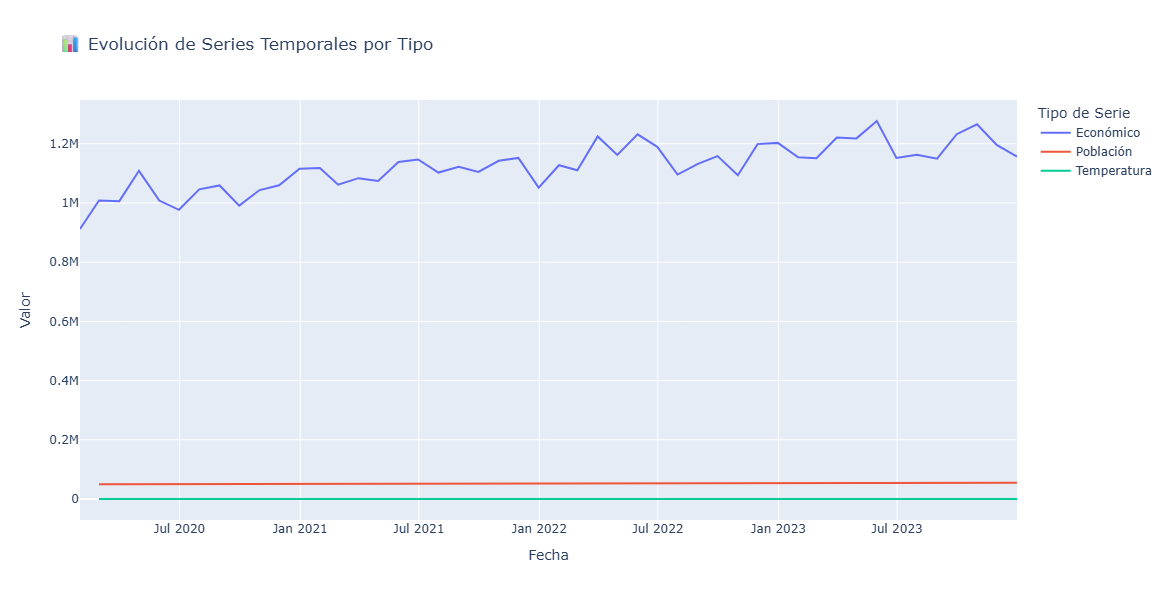

✅ Gráfico de series temporales creado


In [6]:

# 📈 VISUALIZACIÓN 1: SERIES TEMPORALES POR TIPO
# =============================================

fig = px.line(datos, x='fecha', y='valor', color='tipo', 
              title='📊 Evolución de Series Temporales por Tipo',
              labels={'valor': 'Valor', 'fecha': 'Fecha', 'tipo': 'Tipo de Serie'},
              hover_data=['categoria', 'hoja'])

fig.update_layout(
    height=600,
    xaxis_title="Fecha",
    yaxis_title="Valor",
    legend_title="Tipo de Serie",
    hovermode='x unified'
)

fig.show()

print("✅ Gráfico de series temporales creado")

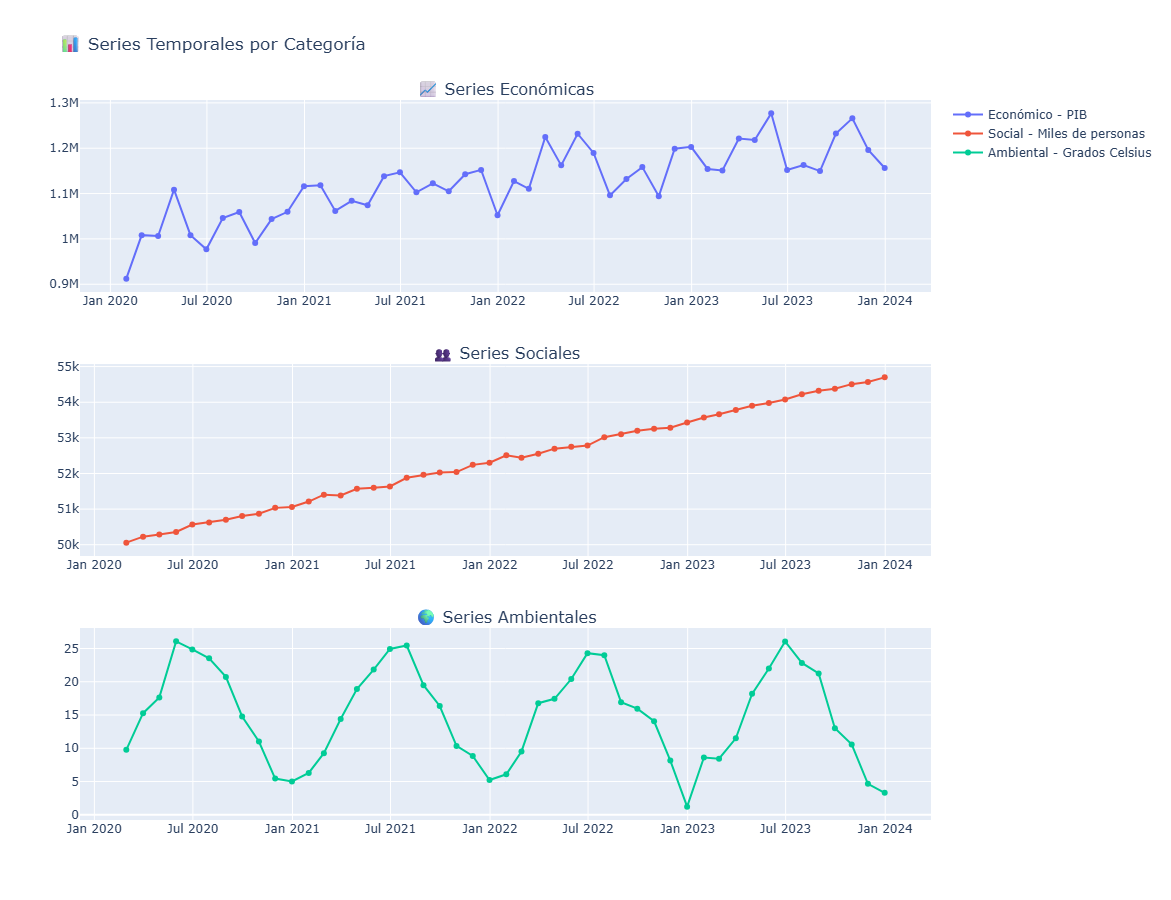

✅ Gráfico por categorías creado


In [7]:
# 📊 VISUALIZACIÓN 2: SERIES SEPARADAS POR CATEGORÍA
# =================================================

# Crear subgráficos para cada tipo
fig = make_subplots(
    rows=3, cols=1,
    subplot_titles=['📈 Series Económicas', '👥 Series Sociales', '🌍 Series Ambientales'],
    vertical_spacing=0.1
)

# Económicas
econ_data = datos[datos['tipo'] == 'Económico']
for categoria in econ_data['categoria'].unique():
    data_cat = econ_data[econ_data['categoria'] == categoria]
    fig.add_trace(
        go.Scatter(x=data_cat['fecha'], y=data_cat['valor'], 
                  mode='lines+markers', name=f'Económico - {categoria}'),
        row=1, col=1
    )

# Sociales (Población)
social_data = datos[datos['tipo'] == 'Población']
for categoria in social_data['categoria'].unique():
    data_cat = social_data[social_data['categoria'] == categoria]
    fig.add_trace(
        go.Scatter(x=data_cat['fecha'], y=data_cat['valor'], 
                  mode='lines+markers', name=f'Social - {categoria}'),
        row=2, col=1
    )

# Ambientales (Temperatura)
amb_data = datos[datos['tipo'] == 'Temperatura']
for categoria in amb_data['categoria'].unique():
    data_cat = amb_data[amb_data['categoria'] == categoria]
    fig.add_trace(
        go.Scatter(x=data_cat['fecha'], y=data_cat['valor'], 
                  mode='lines+markers', name=f'Ambiental - {categoria}'),
        row=3, col=1
    )

fig.update_layout(height=900, title_text="📊 Series Temporales por Categoría")
fig.show()

print("✅ Gráfico por categorías creado")

📊 ESTADÍSTICAS POR TIPO:

🔹 Económico:
   Media: 1,122,946.37
   Mediana: 1,129,791.54
   Mín: 912,279.54
   Máx: 1,276,906.49
   Registros: 48

🔹 Población:
   Media: 52,394.44
   Mediana: 52,439.62
   Mín: 50,058.47
   Máx: 54,698.02
   Registros: 47

🔹 Temperatura:
   Media: 14.91
   Mediana: 15.27
   Mín: 1.22
   Máx: 26.08
   Registros: 47


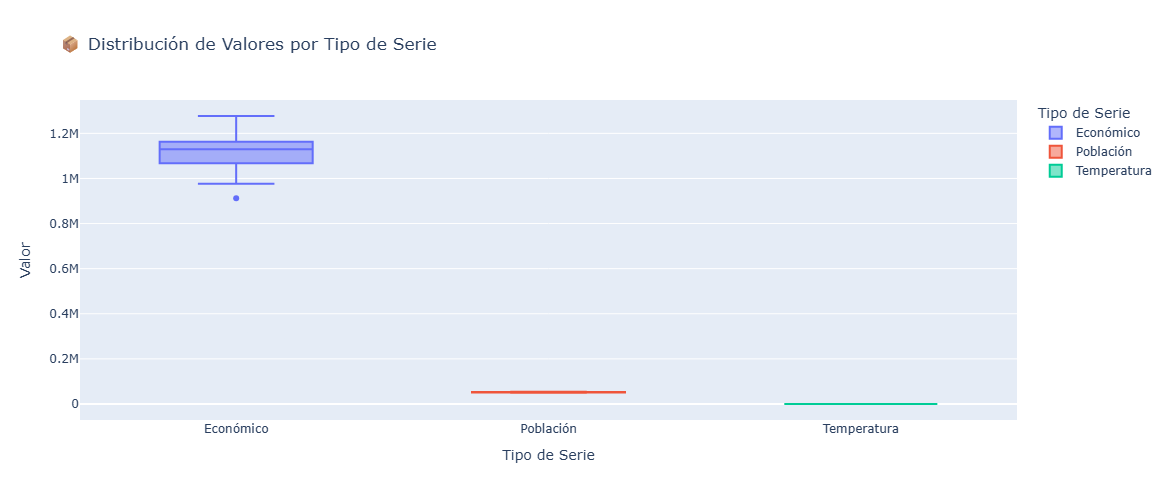


✅ Estadísticas y box plot creados


In [8]:
# 📈 VISUALIZACIÓN 3: DISTRIBUCIÓN DE VALORES
# ==========================================

# Estadísticas básicas
print("📊 ESTADÍSTICAS POR TIPO:")
print("=" * 50)
for tipo in datos['tipo'].unique():
    data_tipo = datos[datos['tipo'] == tipo]
    print(f"\n🔹 {tipo}:")
    print(f"   Media: {data_tipo['valor'].mean():,.2f}")
    print(f"   Mediana: {data_tipo['valor'].median():,.2f}")
    print(f"   Mín: {data_tipo['valor'].min():,.2f}")
    print(f"   Máx: {data_tipo['valor'].max():,.2f}")
    print(f"   Registros: {len(data_tipo)}")

# Box plot
fig = px.box(datos, x='tipo', y='valor', color='tipo',
             title='📦 Distribución de Valores por Tipo de Serie',
             labels={'valor': 'Valor', 'tipo': 'Tipo de Serie'})

fig.update_layout(height=500)
fig.show()

print("\n✅ Estadísticas y box plot creados")

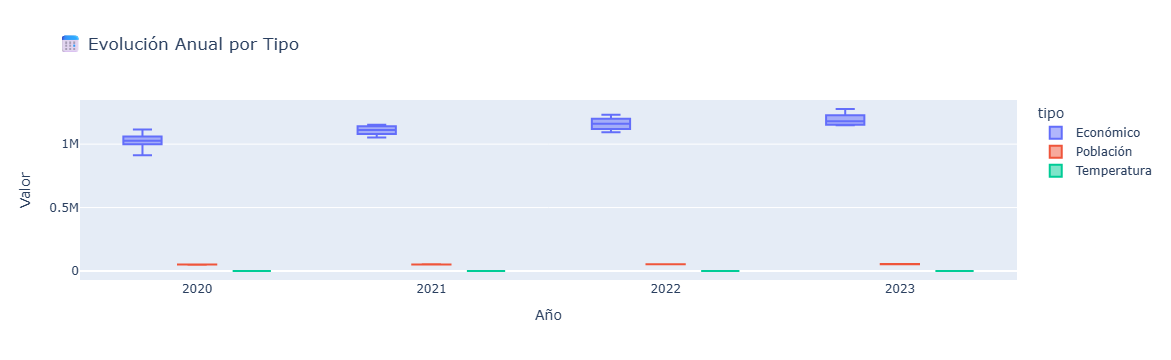

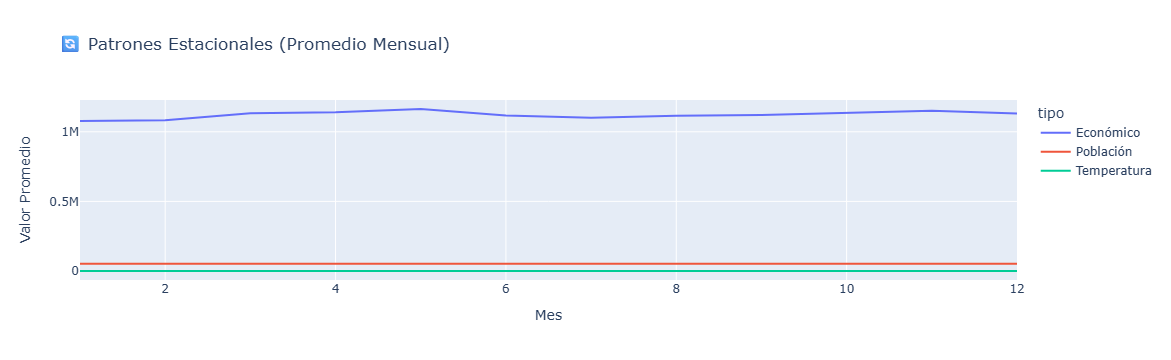

✅ Análisis temporal completado


In [9]:
# 📅 VISUALIZACIÓN 4: ANÁLISIS TEMPORAL
# ====================================

# Agregar columnas temporales
datos['año'] = datos['fecha'].dt.year
datos['mes'] = datos['fecha'].dt.month
datos['trimestre'] = datos['fecha'].dt.quarter

# Evolución anual
fig_anual = px.box(datos, x='año', y='valor', color='tipo',
                   title='📅 Evolución Anual por Tipo',
                   labels={'valor': 'Valor', 'año': 'Año'})
fig_anual.show()

# Patrones estacionales
fig_estacional = px.line(datos.groupby(['mes', 'tipo'])['valor'].mean().reset_index(), 
                        x='mes', y='valor', color='tipo',
                        title='🔄 Patrones Estacionales (Promedio Mensual)',
                        labels={'valor': 'Valor Promedio', 'mes': 'Mes'})
fig_estacional.show()

print("✅ Análisis temporal completado")